<!--
---
title: "Linear Regression."
author: "Darya Vanichkina"
keypoints: 
- Regression is the prediction of the value of a continuous variable based on one or more other continuous or categorical variables.
- Multiple types of regression can be implemented to fit the data

questions:
- How do we preprocess our data for modelling?
- How do we fit a basic linear model using scikit-learn?

objectives:
- To use sklearn.preprocessing to preprocess our data
- To fit and compare some basic linear models using one, two, or all of the variables in the dataset

source: Rmd
teaching: 30
exercises: 15
bibliography: references.bib
---
-->

## Linear regression

In [1]:
# when delivering live coding, these libraries have already been loaded
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import exp10
%matplotlib inline
sns.set(font_scale = 1.5)
#
#
#
# do import these for the next sections to work:
from sklearn.pipeline import Pipeline
from pandas.api.types import CategoricalDtype
import pickle 

from sklearn.preprocessing import (
    StandardScaler, PolynomialFeatures, FunctionTransformer
)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

Define some functions to help us one hot encode variables, group together infrequently occuring cases, and create a "none of this feature" column.

In [2]:
# do live code the next code chunk
def onehot_row_drop(df, column = 'column'):
    dummies = pd.get_dummies(df[column], drop_first=True, prefix=column)
    df = pd.concat([df.drop(column, axis=1), dummies],axis=1)
    return(df)

def group_infrequent(df, column_name, counts = 10):
    frequencies = df[column_name].value_counts()
    infrequent = frequencies[frequencies <= counts].index
    df.loc[df[column_name].isin(infrequent), column_name] = "Other"

def none_of_this_feature(df, column = 'column'):
    # adds a column to the dataframe with a value of 0 where there is none of this feature,
    # and a 1 where it's actually there
    df['No_' + column] = np.where(df[column]==0, 0, 1)
    return(df)

In [3]:
# you don't need to reload the data
# this is just here to make the note generation work
ameshousingClean = pd.read_csv('data/AmesHousingClean.csv')
ameshousingClean = ameshousingClean.loc[ameshousingClean['Gr_Liv_Area'] <= 4000, :]
#
#
#
#

In [4]:
# But DO copy-paste the below code to proceed to the challenge
# step 1
ameshousingClean['Age'] = ameshousingClean['Year_Sold'].max() - ameshousingClean['Year_Built']
ameshousingClean['Remodel_Age'] = ameshousingClean['Year_Sold'].max() - ameshousingClean['Year_Remod_Add']
ameshousingClean['Misc_Feature_Present'] =  np.where(ameshousingClean['Misc_Feature']=="None", 0, 1)


# step 2
# group situations where there are less than 20 cases of something
infrequent_cols = ['Neighborhood', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd', 
                   'Heating', 'MS_Zoning', 'Misc_Feature', 'Sale_Type']
for col in infrequent_cols:
    group_infrequent(df=ameshousingClean, column_name=col, counts=20)


# Capture variables where some houses have "none of this feature" (i.e value of parameter = 0 aka zero-inflation)
none_of_feature = ['Second_Flr_SF','Three_season_porch','BsmtFin_SF_2','Bsmt_Unf_SF',
                   'Enclosed_Porch','Low_Qual_Fin_SF', 'Mas_Vnr_Area','Lot_Frontage',
                   'Open_Porch_SF','Screen_Porch','Pool_Area','Wood_Deck_SF', 
                   'BsmtFin_SF_2', 'Second_Flr_SF']
for col in none_of_feature:
    ameshousingClean = none_of_this_feature(df = ameshousingClean, column=col)
    
# step 3
categorical_variable_list = ['Alley', 'Bldg_Type', 'Condition_1', 'Electrical', 'Exter_Cond', 'Exter_Qual', 
                             'Foundation', 'Functional', 'House_Style', 'Kitchen_Qual', 'Land_Contour', 
                             'Land_Slope', 'Lot_Config', 'Lot_Shape', 'Central_Air', 'Bsmt_Cond', 
                             'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Qual', 'Fence', 
                             'Fireplace_Qu', 'Garage_Cond', 'Garage_Finish', 'Garage_Type', 'Heating_QC',  
                              'MS_SubClass',  'Overall_Cond', 'Overall_Qual', 
                             'Paved_Drive', 'Roof_Style', 'Year_Sold', 'Neighborhood', 'Roof_Matl', 'Exterior_2nd',
                            'Exterior_1st', 'Heating', 'MS_Zoning', 'Misc_Feature', 'Street', 
                             'Mas_Vnr_Type', 'Utilities',"Condition_2", "Pool_QC", "Garage_Qual", 'Sale_Type', 
                             'Sale_Condition']

# step 4
# one hot encode the other categoricals
for col in categorical_variable_list:
    ameshousingClean = onehot_row_drop(df = ameshousingClean, column=col)

# step 5
# drop double no basement: (ranges from 80 to 83 in dataset, going with 80)
columns_to_drop = [
    'Bsmt_Exposure_No_Basement','BsmtFin_Type_2_No_Basement','Bsmt_Qual_No_Basement',
    'Garage_Finish_No_Garage','Garage_Type_No_Garage','Garage_Qual_No_Garage',
    'Year_Built','Year_Remod_Add',
]
ameshousingClean = ameshousingClean.drop(columns_to_drop, axis=1)

> ## Challenge 1
>
> Look at the code above. Can you explain why each of these transformations is being carried out? 
> See if you can figure out, in your groups, what each of the steps is doing.
> 
> {: .source}
>
> > ## Solution
> > 
> > {: .output}
> {: .solution}
{: .challenge}

Add a column to the dataset to split the Sale Price by percentile into 10 bins:

In [5]:
ameshousingClean['Sale_Price_quartile'] =  pd.qcut(ameshousingClean['Sale_Price'], 10, 
                                                   labels=range(10))

Now we can use scikit-learn's train-test split to split the data into a training and testing subset, stratifying it by the percentile bin of the Sale_Price:

In [6]:
index_train, index_test  = train_test_split(
    ameshousingClean.index.values, train_size=0.7, test_size = 0.3, 
    stratify = ameshousingClean['Sale_Price_quartile'].values, random_state=42
)
#
#
## get rid of the quartile column so we're not using it to predict sale price
ameshousingClean = ameshousingClean.drop('Sale_Price_quartile', axis = 1)

# Create variables for the training and test sets 
ames_train = ameshousingClean.loc[index_train,:].copy()
ames_test = ameshousingClean.loc[index_test,:].copy()

In [7]:
# What are their dimensions?
print(ames_train.shape)
print(ames_test.shape)

(2047, 287)
(878, 287)


Get a list of predictor names and make numpy matrices of the data:

In [8]:
predictors = ameshousingClean.columns.values.tolist()
predictors.remove('Sale_Price')

# this is extra, to help keep  the train/test consistent between different page renders
# in jekyll. Not necessary for teaching
pickle.dump(predictors, open('models/predictors.pickle', 'wb'))

In [9]:
# define a transformation function for the Y
log_transf_f = FunctionTransformer(
    func=np.log10,
    inverse_func=exp10,
    validate=True
)

In [10]:
# Create training and test response vectors
ames_train_y = log_transf_f.fit_transform(ames_train['Sale_Price'].values.reshape(-1, 1))
ames_test_y = log_transf_f.transform(ames_test['Sale_Price'].values.reshape(-1, 1))

# Write training and test design matrices
ames_train_X = ames_train[predictors].copy()
ames_test_X = ames_test[predictors].copy()


# save them to files as well (this is an extra step that's not necessary in class, but useful for our jupyter notebook class notes)
pickle.dump(ames_train_y, open('models/ames_train_y.pickle', 'wb'))
pickle.dump(ames_test_y, open('models/ames_test_y.pickle', 'wb'))
pickle.dump(ames_train_X, open('models/ames_train_X.pickle', 'wb'))
pickle.dump(ames_test_X, open('models/ames_test_X.pickle', 'wb'))

In [11]:
type(ames_train_X)

pandas.core.frame.DataFrame

In [12]:
type(ames_train_y)

numpy.ndarray

## Fit OLS models with different features

In [13]:
## Fit an Ordinary Least Squares Regression using all variables
ames_ols_all = LinearRegression()
ames_ols_all.fit(ames_train_X, ames_train_y)


## Fit an Ordinary Least Squares Regression using Gr_Liv_Area
ames_ols_GrLivArea = LinearRegression()
# Note: need [] around the column name so it is kept as a dataframe
ames_ols_GrLivArea.fit(ames_train_X.loc[:, ['Gr_Liv_Area']], ames_train_y)

## 
ames_ols_Second_Flr_SF = LinearRegression()
ames_ols_Second_Flr_SF.fit(ames_train_X.loc[:, ['Second_Flr_SF']], ames_train_y)

## Fit an Ordinary Least Squares Regression using Gr_Liv_Area and Second_Flr_SF
ames_ols_GrLivArea_Second_Flr_SF = LinearRegression()
ames_ols_GrLivArea_Second_Flr_SF.fit(ames_train_X[['Gr_Liv_Area','Second_Flr_SF']], ames_train_y)

## Fit an Ordinary Least Squares Regression using Gr_Liv_Area and Age
ames_ols_GrLivArea_Age = LinearRegression()
ames_ols_GrLivArea_Age.fit(ames_train_X[['Gr_Liv_Area','Age']], ames_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Assess model fit

Assess model fit on the training data:

In [14]:
## Paste the function below, then go slowly through how it is built up
def assess_fit_vars(models, variables, datasetX, datasetY):
    columns = ['RMSE', 'R2', 'MAE']
    results = pd.DataFrame(0.0, columns=columns, index=variables)
    # compute the actual Y
    y_actual = log_transf_f.inverse_transform(datasetY)
    for i, method in enumerate(models):
        if variables[i] != "All":
            tmp_dataset_X = datasetX[variables[i]]
            if type(variables[i]) == str: #only one column - so need to reshape
                tmp_dataset_X = datasetX[variables[i]].values.reshape(-1, 1)
        else:
            tmp_dataset_X = datasetX
        # while we build the model and predict on the log10Transformed sale price, we display the error in dollars
        # as that makes more sense
        y_pred = log_transf_f.inverse_transform(method.predict(tmp_dataset_X))
        results.iloc[i,0] = np.sqrt(
            mean_squared_error(y_actual, y_pred))
        results.iloc[i,1] = r2_score(y_actual, y_pred)
        results.iloc[i,2] = mean_absolute_error(y_actual, y_pred)
    return results.round(3)

models = [ames_ols_all, ames_ols_GrLivArea, ames_ols_Second_Flr_SF, 
          ames_ols_GrLivArea_Age, ames_ols_GrLivArea_Second_Flr_SF]

variables = ["All", 'Gr_Liv_Area','Second_Flr_SF',
            ['Gr_Liv_Area', 'Age'], ['Gr_Liv_Area', 'Second_Flr_SF']]

compare_train = assess_fit_vars(
    models=models,
    variables=variables, 
    datasetX=ames_train_X, 
    datasetY=ames_train_y
)
compare_train.sort_values('RMSE')

,RMSE,R2,MAE
All,15757.714,0.961,10931.668
"[Gr_Liv_Area, Age]",42838.016,0.709,29175.241
"[Gr_Liv_Area, Second_Flr_SF]",54774.347,0.524,36413.963
Gr_Liv_Area,57157.444,0.481,39045.817
Second_Flr_SF,78064.434,0.033,53060.044


Let's built a comparison plot

In [15]:
# rearrange the scores df to for the plot
def rearrange_df(df):
    out_df = (
        df.copy()
        .reset_index()
        .melt(
            id_vars='index',
            value_vars=df.columns.values.tolist(),
            var_name='metric',
            value_name='number'
        )
        .sort_values('number')
    )
    out_df['index'] = out_df['index'].astype(str)
    out_df= out_df.rename(columns={'index':'model_features'})
    return out_df

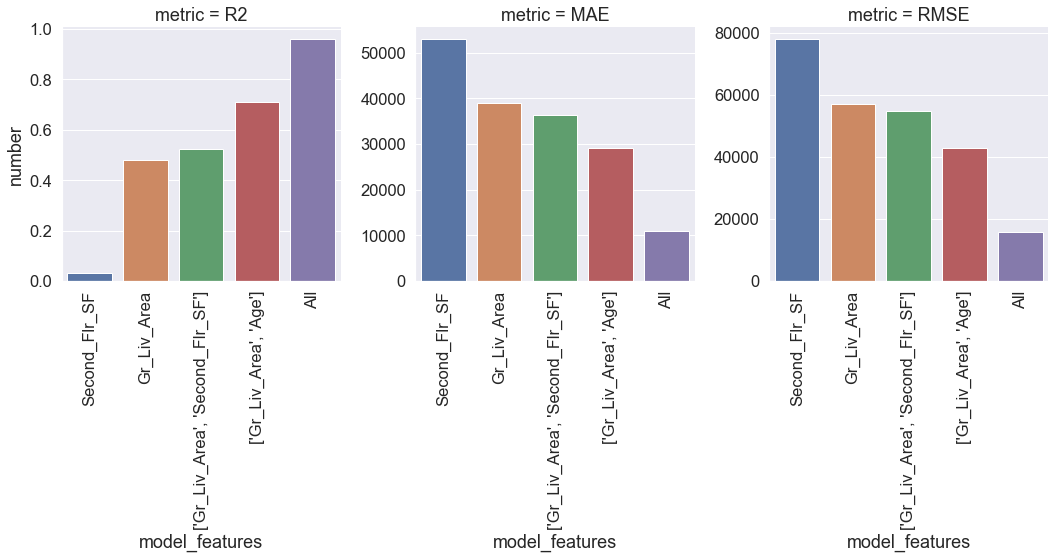

In [16]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(compare_train),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);

Compare with peformance on the test set

In [17]:
# on the test! set
compare = assess_fit_vars(
    models=models, variables=variables, 
    datasetX=ames_test_X, datasetY=ames_test_y
)
compare.sort_values('RMSE')

,RMSE,R2,MAE
All,20541.485,0.928,13346.733
"[Gr_Liv_Area, Age]",39888.647,0.729,27876.134
"[Gr_Liv_Area, Second_Flr_SF]",49934.445,0.575,35199.582
Gr_Liv_Area,55373.269,0.477,37740.468
Second_Flr_SF,73795.736,0.071,51293.938


Let's compare the scores across train and test sets

In [18]:
# combine test and train dfs
def combine_train_test_res_df(df_train_scores, df_test_scores):
    df = rearrange_df(df_train_scores)
    df['dataset'] = 'train'
    df1 = rearrange_df(df_train_scores)
    df1['dataset'] = 'test'
    return df.append(df1)

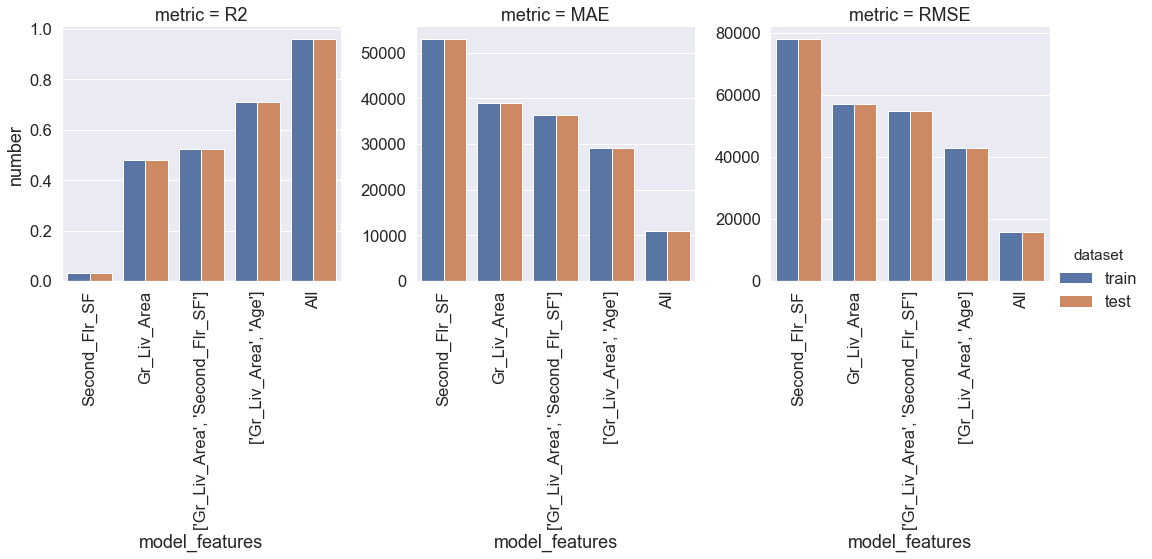

In [19]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=combine_train_test_res_df(compare_train, compare),
    kind='bar',
    sharey=False,
    hue='dataset'
)
chart.set_xticklabels(rotation=90);

In [20]:
# lets explore the coefficients
print(ameshousingClean.columns.get_loc('Gr_Liv_Area'))
print(ameshousingClean.columns.get_loc('Age'))
print(ameshousingClean.columns.get_loc('Second_Flr_SF'))

10
32
8


> ## Challenge 2
>
> 1. Explore the coefficients for Gr_Liv_Area, Second_Flr_SF,  Gr_Liv_Area + Second_Flr_SF, 
> Gr_Liv_Area + Age, and the coefficients for these parameters for a model that 
> incorporates all of them. What do you observe? Are the coefficients for each parameter consistent among all the models?
>
> 2. Which model performs the best? Why? 
>
> 3. Does the same model perform best for the training and test data? Why?
>
>
>
> {: .source}
>
> > ## Solution
> > 
> > This is a discussion challenge. Answers will be discussed as a group. 
> > To get the coefficients for each model, use the `ames_ols_GrLivArea.coef_` method.
> > ~~~
> > ames_ols_GrLivArea.coef_
> > ames_ols_Second_Flr_SF.coef_
> > ames_ols_GrLivArea_Age.coef_
> > ames_ols_GrLivArea_Second_Flr_SF.coef_
> > ~~~
> > 
> > {: .output}
> {: .solution}
{: .challenge}

In [21]:
# the below is only necessary to build the web pages; do not use for class
# save OLS model to pickle
pickle.dump(ames_ols_all, open('models/ames_ols_all.pickle', 'wb'))

## Extra: interactions

We can also use some of the `scikit-learn` tools to create interaction
terms, e.g. an interaction between the ground floor living area
and second floor square footage. This is a little bit harder to integrate with 
our previous models (as we have to create a dataset with a new interaction term in it),
so it has been kept separate:

In [22]:
# Create interaction term (not polynomial features) 
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True) 
X_inter = interaction.fit_transform(ames_train_X[['Gr_Liv_Area','Second_Flr_SF']])
X_inter = pd.DataFrame(
    X_inter, 
    columns = interaction.get_feature_names(['Gr_Liv_Area','Second_Flr_SF'])
)
ames_ols_GrLivArea_Second_Flr_SF_interaction = LinearRegression() 
ames_ols_GrLivArea_Second_Flr_SF_interaction.fit(X_inter, ames_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# Training performance
assess_fit_vars(
    models=[ames_ols_GrLivArea_Second_Flr_SF_interaction], 
    variables=["All"], 
    datasetX=X_inter, datasetY=ames_train_y
)

,RMSE,R2,MAE
All,55222.314,0.516,36406.468


In [24]:
# Test performance
X_inter_test = interaction.fit_transform(ames_test_X[['Gr_Liv_Area','Second_Flr_SF']])
X_inter_test = pd.DataFrame(
    X_inter_test, 
    columns = interaction.get_feature_names(['Gr_Liv_Area','Second_Flr_SF'])
)

assess_fit_vars(
    models=[ames_ols_GrLivArea_Second_Flr_SF_interaction], 
    variables=["All"], 
    datasetX=X_inter_test, datasetY=ames_test_y
)

,RMSE,R2,MAE
All,49301.482,0.585,35003.994
